In [1]:
# Utility 
import pickle
import toml

# Data manipulation
import pandas as pd
import numpy as np

# Machine learning
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

#Additional
from features.preprocessing import data_preprocessor, dataframe_preprocessor
from features.fake_news_classifier import TFIDFTransform, FakeNewsClassifier

In [3]:
CONFIG_PATH = "../config.toml"
config = toml.load(CONFIG_PATH)

global_cfg = config["global"]

In [4]:
bodies = pd.read_csv("../data/bodies.csv", )
stances = pd.read_csv("../data/stances.csv")

In [5]:
X, y = dataframe_preprocessor(bodies, stances)

In [6]:
label_encoder = LabelEncoder()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = global_cfg["test_size"], random_state=global_cfg["random_state"])
X_train_rel, X_train_cls, y_train_rel, y_train_cls, train_cls_indices = data_preprocessor(X_train, y_train, label_encoder)
X_test_rel, X_test_cls, y_test_rel, y_test_cls, test_cls_indices = data_preprocessor(X_test, y_test, label_encoder)

In [7]:
rel_classifier = xgb.Booster()
rel_classifier.load_model("../models/rel_classifier.json")

cls_classifier = xgb.Booster()
cls_classifier.load_model("../models/cls_classifier.json")

with open("../models/transform.pkl", "rb") as f:
    tfidf_transform = pickle.load(f)

In [8]:
classifier = FakeNewsClassifier(rel_classifier, cls_classifier, tfidf_transform)

In [9]:
y_pred, y_true = classifier.predict_test(X_test_rel, y_test_rel, 
                                        X_test_cls, y_test_cls, 
                                        test_cls_indices, y_org=y_test)

In [10]:
classifier.print_metrics(y_true, y_pred)

Precision = 0.9026399951697065
Recall = 0.8726834739884045
Accuracy = 0.947324761509747
Balanced accuracy = 0.8726834739884045


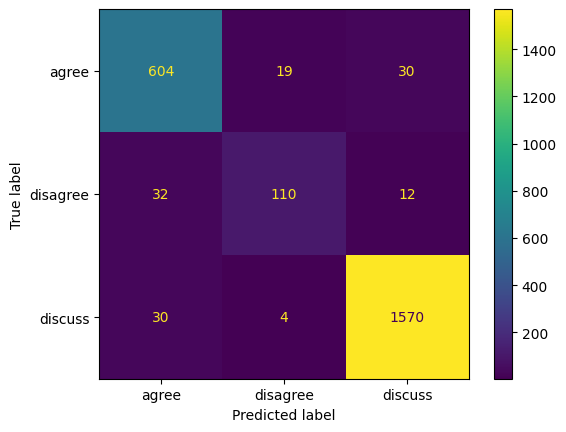

In [11]:
classifier.plot_cm(y_true, y_pred, labels=label_encoder.classes_)